<h1><center> Road Traffic Accidents Severity Classification </center></h1>

### Contents

- *Introduction*
- *Exploration des Data*
- *Pretraitement des données*
- *Modélisation*
- *Prediction and Evaluation*
- *Auto Ml*
- *Ml Flow*
- *SHAP et LIME*

In [ ]:
# Gestion du système de fichiers
import time, psutil, os, random

# Fonctions mathématiques
import math

# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation et graphiques
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()  # Applique un thème par défaut aux graphiques


# Imputation des données manquantes
from sklearn.experimental import enable_iterative_imputer  # Active l'imputation itérative
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer  # Imputation de données manquantes par différentes méthodes

# Encodage des données catégorielles
from sklearn.preprocessing import LabelEncoder  # Convertir les variables catégorielles en variables numériques

# Séparation des données en ensembles d'entraînement et de test, et validation croisée en k-plis
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Sélection des caractéristiques
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif  # Méthodes pour sélectionner les caractéristiques les plus importantes

# Évaluation des modèles
from sklearn import metrics  # Outils pour évaluer les performances des modèles
from sklearn.metrics import f1_score  # Mesure de la performance F1 (précision et rappel)

## Intelligence artificielle explicable (explainable AI)
#!pip install --quiet shap==0.39.0  # Installation de la bibliothèque SHAP pour l'interprétabilité des modèles
#import shap  # Importation de SHAP pour rendre les modèles plus transparents et compréhensibles

# Suppression des avertissements
import warnings
warnings.filterwarnings('ignore')  # Ignore les avertissements pour une sortie plus propre



## 1. Introduction

#### 1.1. Data 

Source : [https://www.kaggle.com/saurabhshahane/road-traffic-accidents](https://www.kaggle.com/saurabhshahane/road-traffic-accidents)

Le jeu de données a été préparé à partir des enregistrements manuels des accidents de la route survenus entre 2017 et 2020, collectés auprès des départements de police des sous-villes d'Addis-Abeba. Les informations sensibles ont été exclues lors du processus d'encodage des données. Le jeu de données final contient des informations sur 12 316 accidents, chacun avec 32 caractéristiques.

In [6]:
data = pd.read_csv('./RTA Dataset.csv')  # Chargement du jeu de données  pour l'analyse

In [7]:
data.head()  # Afficher les 5 premières lignes du DataFrame pour avoir un aperçu rapide des données

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


#### 1.2. Objectif du Projet

Le jeu de données contient des informations détaillées sur 12 316 accidents. Il comporte 31 variables prédictives et la variable cible *Accident_severity* qui peut prendre trois valeurs possibles : Léger, Grave et Mortel. L'objectif du projet est de construire des modèles de prédiction afin de classer la gravité d'un accident comme étant légère, grave ou mortelle, en fonction des informations pertinentes fournies par les 31 variables prédictives relatives à chaque accident particulier.

#### 1.3. Métrique d'Évaluation 

La précision (Precision) et le rappel (Recall) sont des métriques universellement acceptées pour évaluer la performance d'un modèle, respectivement limitées à la classe positive prédite et à la classe positive réelle. Soit :

- TP : Nombre de vrais positifs
- TN : Nombre de vrais négatifs
- FP : Nombre de faux positifs
- FN : Nombre de faux négatifs

En termes de ces quantités, la précision et le rappel sont définis comme suit :

- **Précision** = \(\frac{TP}{TP + FP}\)
- **Rappel** = \(\frac{TP}{TP + FN}\)

Le score F1 fournit une mesure équilibrée en considérant la moyenne harmonique de ces deux matrices.

- **Score F1** = \(\frac{2 \times \text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}\)

En raison de son égalité de poids accordée à la fois à la précision et au rappel, le score F1 est l'une des métriques les plus appropriées pour évaluer les modèles dans ce projet. Dans le jeu de données, nous avons une variable cible (*Accident_severity*) qui prend trois valeurs possibles, ce qui partitionne essentiellement le jeu de données en trois classes cibles. Cela peut être converti en une partition binaire en considérant une classe comme la classe positive et les deux autres combinées comme la classe négative. Cette partition positive-négative peut être réalisée du point de vue de chaque classe cible, produisant ainsi trois scores F1. Nous prenons le score F1 pondéré, qui est la moyenne de ces trois scores pondérée par le nombre d'instances réelles pour chaque classe, comme métrique d'évaluation pour évaluer les modèles.





## 2. Analyse Exploratoire des Données
#### 2.1. Exploration Basique des Données

In [37]:
# la taille de la data
print("Shape of the data: {}".format(data.shape))

Shape of the data: (12316, 28)


In [27]:
data.columns # Afficher la liste des noms de colonnes dans le DataFrame

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Area_accident_occured',
       'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction',
       'Road_surface_type', 'Road_surface_conditions', 'Light_conditions',
       'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty',
       'Age_band_of_casualty', 'Casualty_severity', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [9]:
data.info() # Afficher un résumé concis des informations sur le DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [28]:
data.isnull().sum() # Compte le nombre de valeurs manquantes dans chaque colonne du DataFrame

Time                             0
Day_of_week                      0
Age_band_of_driver               0
Sex_of_driver                    0
Educational_level              741
Vehicle_driver_relation        579
Driving_experience             829
Type_of_vehicle                950
Owner_of_vehicle               482
Area_accident_occured          239
Lanes_or_Medians               385
Road_allignment                142
Types_of_Junction              887
Road_surface_type              172
Road_surface_conditions          0
Light_conditions                 0
Weather_conditions               0
Type_of_collision              155
Number_of_vehicles_involved      0
Number_of_casualties             0
Vehicle_movement               308
Casualty_class                   0
Sex_of_casualty                  0
Age_band_of_casualty             0
Casualty_severity                0
Pedestrian_movement              0
Cause_of_accident                0
Accident_severity                0
dtype: int64

In [12]:
data # Affiche le contenu du DataFrame

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Residential areas,...,2,2,Going straight,na,na,na,na,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,Office areas,...,2,2,Going straight,na,na,na,na,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,Recreational areas,...,2,2,Going straight,Driver or rider,Male,31-50,3,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,Office areas,...,2,2,Going straight,Pedestrian,Female,18-30,3,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,Industrial areas,...,2,2,Going straight,na,na,na,na,Not a Pedestrian,Overtaking,Slight Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,16:15:00,Wednesday,31-50,Male,NaN,Employee,2-5yr,Lorry (11?40Q),Owner,Outside rural areas,...,2,1,Going straight,na,na,na,na,Not a Pedestrian,No distancing,Slight Injury
12312,18:00:00,Sunday,Unknown,Male,Elementary school,Employee,5-10yr,Automobile,Owner,Outside rural areas,...,2,1,Other,na,na,na,na,Not a Pedestrian,No distancing,Slight Injury
12313,13:55:00,Sunday,Over 51,Male,Junior high school,Employee,5-10yr,Bajaj,Owner,Outside rural areas,...,1,1,Other,Driver or rider,Male,31-50,3,Not a Pedestrian,Changing lane to the right,Serious Injury
12314,13:55:00,Sunday,18-30,Female,Junior high school,Employee,Above 10yr,Lorry (41?100Q),Owner,Office areas,...,2,1,Other,na,na,na,na,Not a Pedestrian,Driving under the influence of drugs,Slight Injury


In [29]:
data.describe() # Fournit des statistiques descriptives pour les colonnes numériques du DataFrame

,Number_of_vehicles_involved,Number_of_casualties
count,12316.000000,12316.000000
mean,2.040679,1.548149
std,0.688790,1.007179
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,7.000000,8.000000



#### 2.2. Visualisation des Données
La variable cible : Gravité de l'accident  
*Accident_severity* est une variable catégorielle avec trois valeurs possibles.



In [30]:
data['Accident_severity'].unique()  # Affiche les valeurs uniques présentes dans la colonne 'Accident_severity'

array(['Slight Injury', 'Serious Injury', 'Fatal injury'], dtype=object)

In [31]:
data['Accident_severity'].value_counts()  # Compte le nombre d'occurrences de chaque valeur unique dans la colonne 'Accident_severity'

Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64

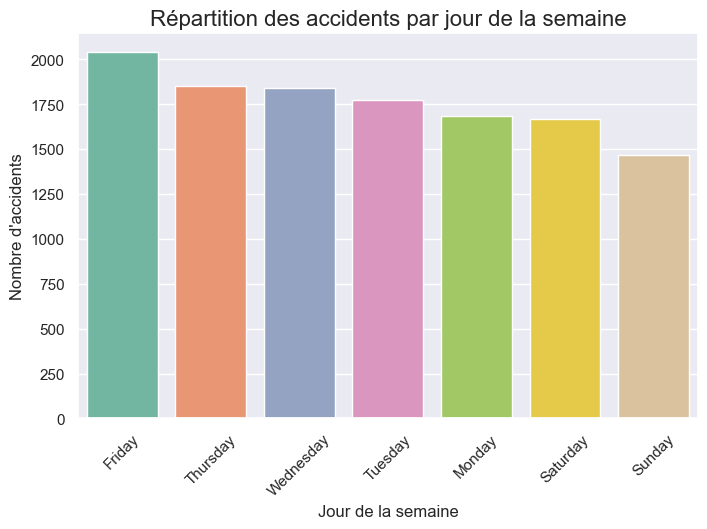

In [32]:
from matplotlib import pyplot as plt  # Importation de la bibliothèque matplotlib pour la création de graphiques
import seaborn as sns  # Importation de seaborn pour des visualisations statistiques avancées

plt.figure(figsize=(8, 5))  # Définir la taille de la figure du graphique

# Création d'un graphique à barres pour compter le nombre d'accidents par jour de la semaine.
sns.countplot(x='Day_of_week', data=data, order=data['Day_of_week'].value_counts().index, palette="Set2")  


plt.title("Répartition des accidents par jour de la semaine", fontsize=16)  # Titre du graphique
plt.xlabel("Jour de la semaine", fontsize=12)  # Label de l'axe des X (jour de la semaine) 
plt.ylabel("Nombre d'accidents", fontsize=12)  # Label de l'axe des Y (nombre d'accidents)

plt.xticks(rotation=45)  # Rotation des labels de l'axe des X de 45 degrés pour les rendre plus lisibles

plt.show()  # Afficher le graphique




### Analyse rapide :
- **Jour avec le plus d'accidents** : Vendredi enregistre le plus grand nombre d'accidents, ce qui peut s'expliquer par une circulation accrue en fin de semaine (sorties, déplacements professionnels ou privés).
- **Jour avec le moins d'accidents** : Dimanche a le plus faible nombre d'accidents, probablement dû à une diminution générale de la circulation ce jour-là.
- Les autres jours de la semaine (lundi à jeudi) montrent des valeurs proches, indiquant une répartition relativement stable des accidents en semaine.


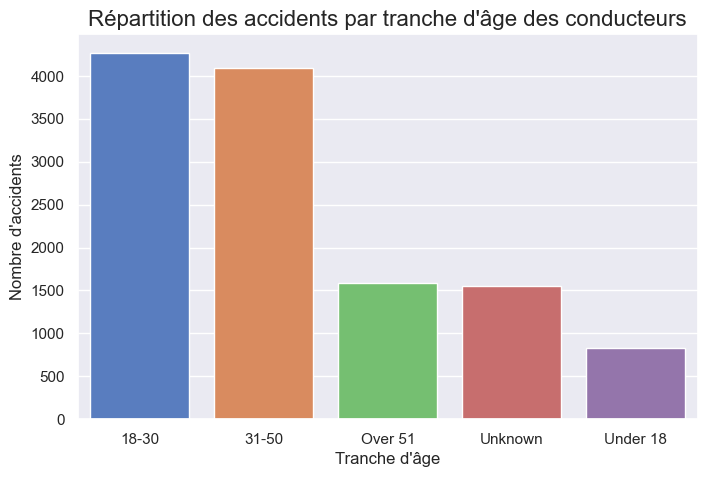

In [18]:
plt.figure(figsize=(8, 5))  # Définir la taille de la figure.


# Créer un graphique à barres (countplot) pour afficher la répartition des accidents en fonction des tranches d'âge des conducteurs.
sns.countplot(x='Age_band_of_driver', data=data, palette="muted", order=data['Age_band_of_driver'].value_counts().index)  

# Ajouter un titre au graphique.
plt.title("Répartition des accidents par tranche d'âge des conducteurs", fontsize=16)  

# Ajouter un label à l'axe des X (tranche d'âge des conducteurs).
plt.xlabel("Tranche d'âge", fontsize=12)  

# Ajouter un label à l'axe des Y (nombre d'accidents).
plt.ylabel("Nombre d'accidents", fontsize=12)  

# Afficher le graphique.
plt.show()  



### Analyse rapide :
Le graphique montre la répartition des accidents en fonction des tranches d'âge des conducteurs. On observe que les conducteurs âgés de **18 à 30 ans** et de **31 à 50 ans** représentent les catégories avec le plus grand nombre d'accidents, avec des chiffres proches et significativement plus élevés que les autres groupes. Les conducteurs de plus de 51 ans, ceux dont l'âge est inconnu, et les conducteurs de moins de 18 ans ont un nombre d'accidents sensiblement inférieur, ces derniers étant les moins impliqués.

Cette répartition peut indiquer que les conducteurs plus jeunes et ceux en âge actif (18-50 ans) sont plus exposés aux accidents, probablement en raison de leur plus grande présence sur la route ou de comportements plus risqués. En revanche, les conducteurs plus âgés ou mineurs semblent moins impliqués, possiblement en raison de leur fréquence de conduite réduite ou de comportements plus prudents.

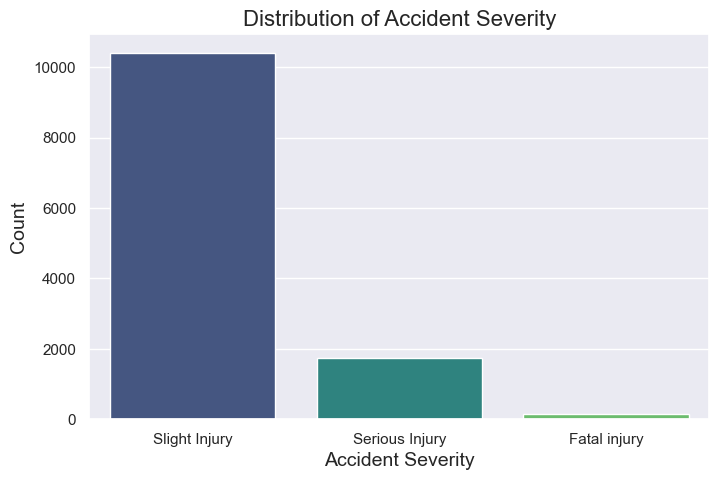

In [33]:
# Comptage des occurrences de chaque catégorie dans la colonne 'Accident_severity'
severity_counts = data['Accident_severity'].value_counts()

# Création d'une figure avec une taille de 8x5 
plt.figure(figsize=(8, 5))

# Création d'un graphique en barres avec les indices de 'severity_counts' sur l'axe des X
# et les valeurs de 'severity_counts' (nombre d'occurrences) sur l'axe des Y
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="viridis")

# Ajout d'un titre au graphique
plt.title('Distribution of Accident Severity', fontsize=16)

# Ajout de l'étiquette pour l'axe des X
plt.xlabel('Accident Severity', fontsize=14)

# Ajout de l'étiquette pour l'axe des Y
plt.ylabel('Count', fontsize=14)

# Affichage du graphique
plt.show()


### Analyse rapide :

Le graphique montre la distribution des accidents selon leur gravité. On observe que la grande majorité des accidents signalés entraînent des **blessures légères**, ce qui peut indiquer que les accidents graves ou mortels sont nettement moins fréquents. Les **blessures graves** représentent une proportion modérée, tandis que les **blessures mortelles** sont très rares, avec un nombre d'occurrences presque négligeable.


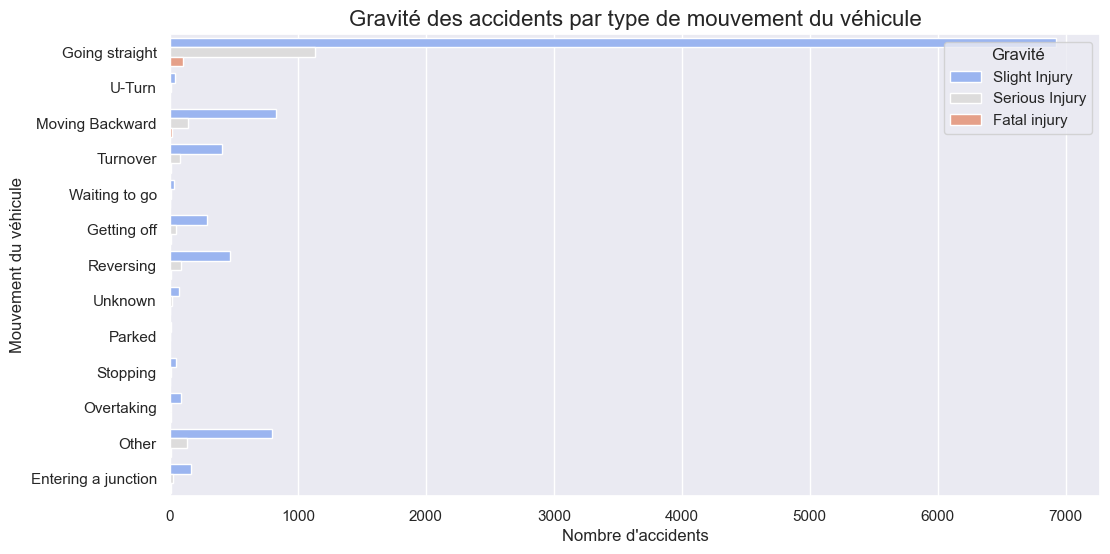

In [20]:
# Définir la taille de la figure.
plt.figure(figsize=(12, 6))  

# Créer un graphique à barres (countplot) horizontal pour afficher la répartition des accidents en fonction du type de mouvement du véhicule.
sns.countplot(y='Vehicle_movement', hue='Accident_severity', data=data, palette="coolwarm")  

# Ajouter un titre au graphique.
plt.title("Gravité des accidents par type de mouvement du véhicule", fontsize=16)  

# Ajouter un label à l'axe des X (nombre d'accidents).
plt.xlabel("Nombre d'accidents", fontsize=12)  

# Ajouter un label à l'axe des Y (type de mouvement du véhicule)
plt.ylabel("Mouvement du véhicule", fontsize=12)  

# Ajouter une légende pour la couleur des barres qui représente la gravité des accidents.
plt.legend(title="Gravité", loc="upper right")  

# Afficher le graphique.
plt.show()  


### Analyse rapide :

Le graphique montre la répartition des accidents en fonction du type de mouvement des véhicules, avec une distinction par gravité (blessures légères, graves ou fatales). On peut tirer les observations suivantes :

1. **Mouvement dominant : "Going Straight"**  
   La majorité des accidents surviennent lorsque les véhicules se déplacent en ligne droite, avec une prédominance de blessures légères. Cela peut s'expliquer par la fréquence élevée de ce type de déplacement et par des accidents typiques comme les collisions avant-arrière.

2. **Accidents notables pour d'autres mouvements :**  
   Des accidents sont également observés pour des mouvements comme **"Moving Backward"**, **"Overtaking"** et **"Entering a junction"**, mais dans des proportions bien moindres.

3. **Gravité :**  
   Les blessures légères dominent dans presque toutes les catégories de mouvement. Les blessures graves et les accidents mortels sont présents mais en nombre relativement faible, ce qui est rassurant en termes de sécurité routière.

4. **Contexte spécifique :**  
   Les types de mouvement comme **"Reversing"** ou **"U-Turn"** ont des fréquences plus faibles d'accidents, mais la gravité peut être variable selon le contexte et les conditions de circulation.



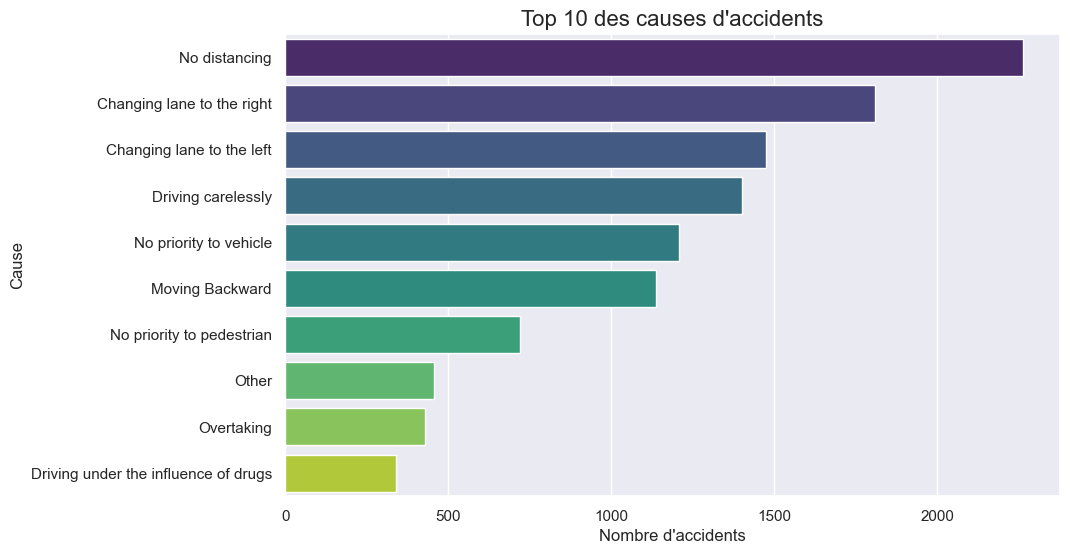

In [34]:
# Définir la taille de la figure à 10 pouces de large et 6 pouces de haut pour une meilleure lisibilité du graphique.
plt.figure(figsize=(10, 6))  

cause_counts = data['Cause_of_accident'].value_counts().head(10)  # Top 10 causes  

# Créer un graphique à barres horizontal (barplot) où l'axe X représente le nombre d'accidents pour chaque cause.
sns.barplot(x=cause_counts.values, y=cause_counts.index, palette="viridis")  

# Ajouter un titre au graphique, avec une taille de police de 16 pour le rendre bien visible.
plt.title("Top 10 des causes d'accidents", fontsize=16)  

# Ajouter un label à l'axe des X (nombre d'accidents).
plt.xlabel("Nombre d'accidents", fontsize=12)  

# Ajouter un label à l'axe des Y (cause de l'accident).
plt.ylabel("Cause", fontsize=12)  

# Afficher le graphique à l'écran.
plt.show()  


### Analyse rapide :

Le graphique montre les 10 principales causes d'accidents, classées par fréquence.

1. **Cause principale : "No distancing"**  
   Cette cause est nettement la plus fréquente avec plus de 2000 incidents, ce qui souligne l'importance du respect des distances de sécurité sur la route.  

2. **Changement de voie**  
   Les comportements liés au changement de voie ("à droite" et "à gauche") sont des causes majeures, indiquant un besoin d'éducation sur la signalisation et la vigilance lors de ces manœuvres.  

3. **Conduite imprudente**  
   La conduite imprudente figure également parmi les causes importantes, ce qui reflète un manque d’attention ou d’adaptation aux conditions de circulation.  

4. **Priorité non respectée**  
   Le non-respect des priorités, qu’il s’agisse de véhicules ou de piétons, est une cause importante, soulignant des comportements dangereux en intersections ou passages piétons.  

5. **Autres observations**  
   - Les accidents liés à des comportements moins fréquents, comme "Driving under the influence of drugs", restent significatifs mais nettement inférieurs aux principales causes.  
   - Les comportements inattentifs, comme "Moving backward", contribuent également au risque routier.  


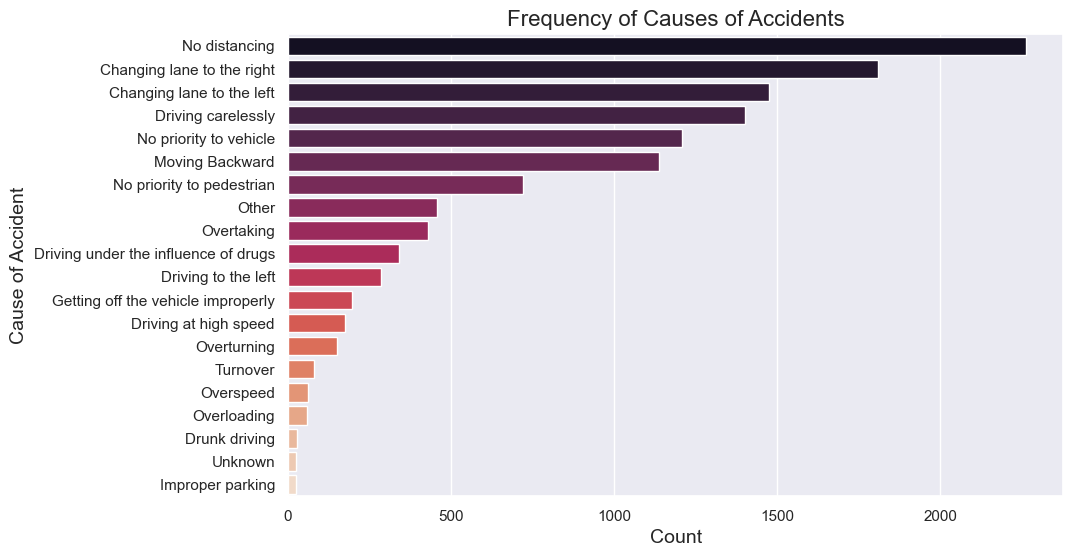

In [35]:
# Création d'une figure avec une taille de 10x6
plt.figure(figsize=(10, 6))

# Création d'un graphique en barres avec countplot pour afficher la fréquence des causes d'accidents
sns.countplot(data=data, y='Cause_of_accident', order=data['Cause_of_accident'].value_counts().index, palette="rocket")

# Ajout d'un titre explicatif au graphique
plt.title('Frequency of Causes of Accidents', fontsize=16)

# Ajout de l'étiquette pour l'axe des X (le nombre d'accidents par cause)
plt.xlabel('Count', fontsize=14)

# Ajout de l'étiquette pour l'axe des Y (les différentes causes d'accidents)
plt.ylabel('Cause of Accident', fontsize=14)

# Affichage du graphique
plt.show()


### Analyse rapide :

Le graphique montre la répartition des accidents en fonction du type de mouvement des véhicules, avec une distinction par gravité (blessures légères, graves ou fatales) :

1. **Mouvement dominant : "Going Straight"**  
   La majorité des accidents surviennent lorsque les véhicules se déplacent en ligne droite, avec une prédominance de blessures légères. Cela peut s'expliquer par la fréquence élevée de ce type de déplacement et par des accidents typiques comme les collisions avant-arrière.

2. **Accidents notables pour d'autres mouvements :**  
   Des accidents sont également observés pour des mouvements comme **"Moving Backward"**, **"Overtaking"** et **"Entering a junction"**, mais dans des proportions bien moindres.

3. **Gravité :**  
   Les blessures légères dominent dans presque toutes les catégories de mouvement. Les blessures graves et les accidents mortels sont présents mais en nombre relativement faible, ce qui est rassurant en termes de sécurité routière.

4. **Contexte spécifique :**  
   Les types de mouvement comme **"Reversing"** ou **"U-Turn"** ont des fréquences plus faibles d'accidents, mais la gravité peut être variable selon le contexte et les conditions de circulation.


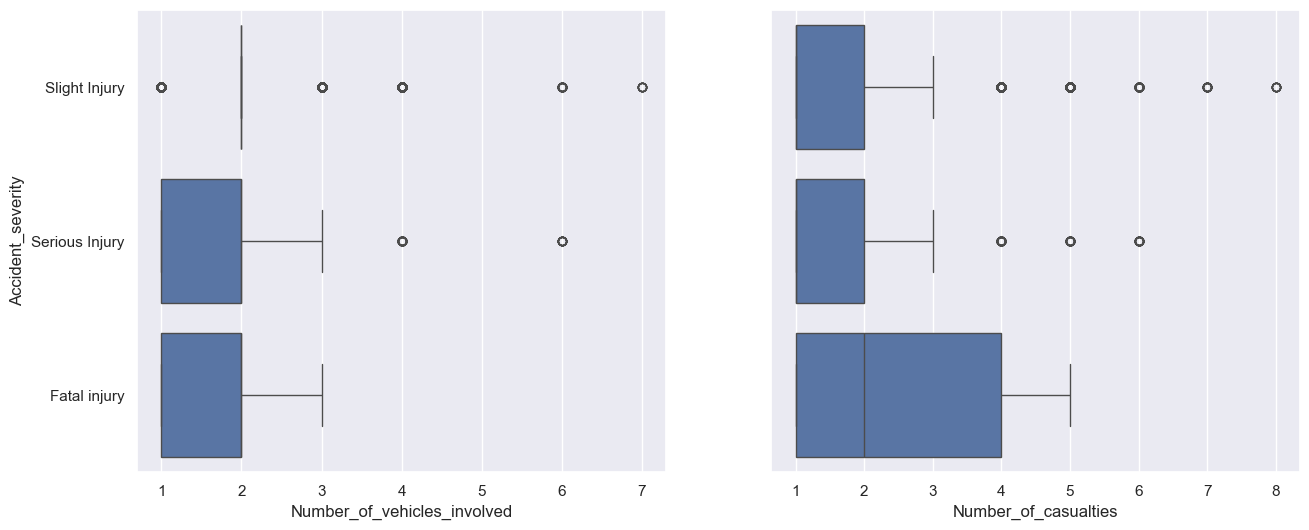

In [24]:
# Création d'une figure avec deux sous-graphes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

# Création d'un graphique en boîte (boxplot) pour visualiser la relation entre le nombre de véhicules impliqués
# et la gravité des accidents.
sns.boxplot(data = data, x = 'Number_of_vehicles_involved', y = 'Accident_severity', ax = ax1)

# Création d'un graphique en boîte (boxplot) pour visualiser la relation entre le nombre de blessés
# et la gravité des accidents.

sns.boxplot(data = data, x = 'Number_of_casualties', y = 'Accident_severity', ax = ax2).set(yticklabels = [])

# Suppression de l'étiquette de l'axe Y du second graphique (ax2)
ax2.set_ylabel('')

# Affichage des deux graphiques côte à côte
plt.show()


Ce graphique comporte deux visualisations en boîte (boxplots) montrant la relation entre la gravité des accidents et deux facteurs clés : le nombre de véhicules impliqués et le nombre de victimes :  

 **1. Nombre de véhicules impliqués**  
   - Les accidents **mortels** (Fatal injury) impliquent souvent **1 à 3 véhicules**. Les valeurs aberrantes (outliers) indiquent que quelques accidents très graves ont impliqué jusqu'à 7 véhicules.  
   - Les accidents **graves** (Serious injury) montrent une tendance similaire, principalement entre **1 et 3 véhicules**, mais avec une distribution un peu plus étendue.  
   - Les accidents avec **blessures légères** (Slight injury) sont fortement concentrés sur des cas avec un seul véhicule impliqué.  

 **2. Nombre de victimes**  
   - Les accidents **mortels** affichent une large distribution du nombre de victimes, allant de **1 à 5**, avec des cas exceptionnels atteignant jusqu'à 8 victimes.  
   - Les accidents **graves** ont généralement entre **1 et 3 victimes**, avec des valeurs aberrantes légèrement plus fréquentes.  
   - Les accidents **légers** sont concentrés autour de **1 ou 2 victimes**, avec très peu de dispersion.  

 **Conclusions :**  
   - **Accidents graves et mortels** : Ils impliquent généralement plusieurs véhicules ou un nombre plus élevé de victimes, reflétant des incidents à fort impact.  
   - **Accidents légers** : Souvent limités à un seul véhicule et un faible nombre de victimes.  


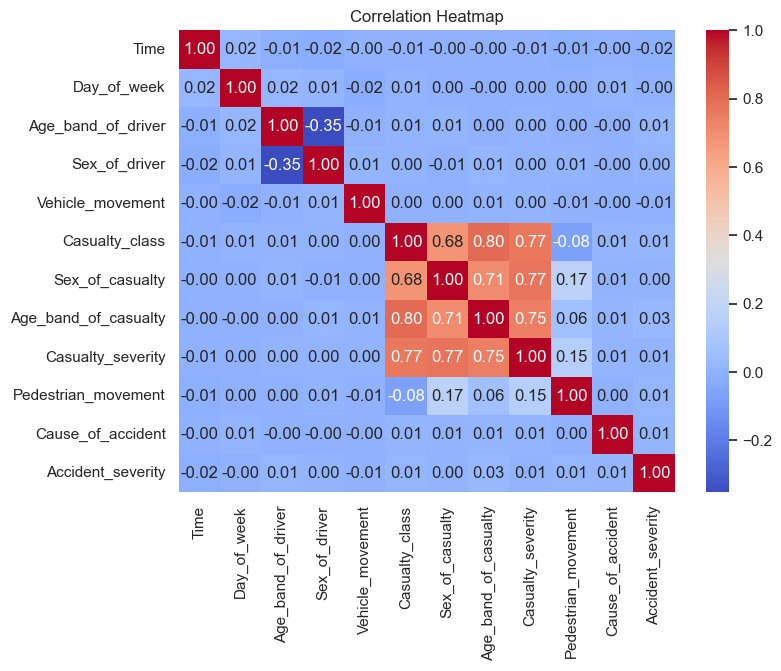

In [36]:
# Choisir les colonnes disponibles et spécifier la colonne cible 
available_columns = [
    "Time", "Day_of_week", "Age_band_of_driver", "Sex_of_driver",
    "Vehicle_movement", "Casualty_class", "Sex_of_casualty",
    "Age_band_of_casualty", "Casualty_severity", "Pedestrian_movement",
    "Cause_of_accident", "Accident_severity"
]

# Sélectionner les colonnes spécifiées dans la liste 'available_columns' à partir du DataFrame 'data'
df_selected = data[available_columns]

# Encoder les colonnes sélectionnées en valeurs numériques (catégorielles -> codes numériques)
# Cela permet de transformer les données catégorielles en données numériques pour pouvoir effectuer une analyse de corrélation
df_encoded = df_selected.apply(lambda col: col.astype('category').cat.codes)

# Calculer la matrice de corrélation entre les colonnes numériques encodées
# Cette matrice montre la force et la direction des relations linéaires entre les variables
correlation_matrix = df_encoded.corr()

# Visualiser la matrice de corrélation sous forme de carte thermique (heatmap)
#  définit les couleurs allant du bleu (corrélation négative) au rouge (corrélation positive)
plt.figure(figsize=(8, 6))  # Définir la taille du graphique
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  
plt.title("Correlation Heatmap")  # Ajouter un titre 
plt.show()  # Afficher le graphique


## Analyse rapide:

Le heatmap de corrélation montre la relation entre plusieurs variables dans votre dataset:

1. *Variables fortement corrélées* :
   - Casualty_class a une forte corrélation positive avec Sex_of_casualty (0.68), Age_band_of_casualty (0.80), et Casualty_severity (0.77). Cela indique que ces variables sont probablement liées de manière significative dans votre dataset. Par exemple, la classe des victimes peut influencer leur gravité ou être liée à leur âge/sexe.
   - Casualty_severity est également fortement corrélé à Age_band_of_casualty (0.75), ce qui pourrait indiquer une tendance entre l'âge et la gravité des blessures.

2. *Corrélations faibles ou nulles* :
   - Plusieurs variables, comme Time, Day_of_week, et Cause_of_accident, montrent peu ou pas de corrélation significative avec les autres variables (valeurs proches de 0). Cela signifie qu'elles n'ont probablement pas d'influence linéaire forte sur d'autres attributs.
   - Par exemple, Time est pratiquement indépendant des autres variables.

3. *Corrélations négatives* :
   - La seule corrélation négative significative visible est entre Pedestrian_movement et Casualty_class (-0.08), bien que la valeur soit assez faible.

4. *Insight général* :
   - Les variables liées à la victime (Casualty_class, Sex_of_casualty, Age_band_of_casualty, Casualty_severity) montrent des relations fortes entre elles, ce qui est logique dans le contexte d'accidents, où des attributs personnels sont souvent interconnectés.
   - Des corrélations faibles ou nulles entre des facteurs tels que Cause_of_accident et d'autres variables suggèrent qu'elles peuvent être influencées par des facteurs externes ou non capturés dans ce dataset.

